In [72]:
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.svm import OneClassSVM
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor, IsolationForest

import lightgbm as lgb


In [3]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [4]:
train.describe()

,WELLNUM,DEPTH,DTC,DTS,BS,CALI,DEN,DENC,GR,NEU,PEF,RDEP,RMED,ROP,PHIF,SW,VSH
count,318967.000000,318967.000000,318967.000000,318967.000000,318967.000000,318967.000000,318967.000000,318967.000000,318967.000000,318967.000000,318967.000000,318967.000000,318967.000000,318967.000000,318967.000000,318967.000000,318967.000000
mean,4.081012,6998.179996,-7791.051225,-8605.136709,-958.267420,-6982.041578,-7000.762197,-7205.371313,-43.026647,-7007.119486,-7221.969013,-949.836141,-804.023955,-989.366887,-8515.777016,-8515.693410,-8585.158486
std,2.462805,3797.936862,4168.057493,3491.479107,2969.159669,4592.475975,4582.288708,4486.572798,990.102434,4578.760758,4480.143550,2944.074718,4177.156020,3028.429856,3554.017382,3554.217716,3484.038870
min,0.000000,335.160105,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000
25%,2.000000,3757.874000,-9999.000000,-9999.000000,8.500000,-9999.000000,-9999.000000,-9999.000000,23.330000,-9999.000000,-9999.000000,0.648200,0.669800,15.197600,-9999.000000,-9999.000000,-9999.000000
50%,4.000000,6905.184000,-9999.000000,-9999.000000,17.500000,-9999.000000,-9999.000000,-9999.000000,55.508400,-9999.000000,-9999.000000,1.102400,1.146000,24.969900,-9999.000000,-9999.000000,-9999.000000
75%,6.000000,10052.490000,-9999.000000,-9999.000000,26.000000,8.556900,2.246500,0.030300,78.978000,0.085100,0.058400,2.020650,2.154900,30.633700,-9999.000000,-9999.000000,-9999.000000
max,8.000000,15651.580000,181.813900,388.839700,36.000000,20.330400,3.089600,0.334158,1124.440000,1.463474,13.840700,80266.800000,97543.400000,208.633000,0.403294,1.000000,3.654300


In [7]:
features = list(train.columns.values[-3:])

In [8]:
col_names =  ['DEN', 'GR', 'NEU', 'PEF', 'RDEP'] + list(train.columns.values[-3:])

# Replace -9999 with np.nan
train.replace(['-9999', -9999], np.nan, inplace=True)

# remove all rows that contains missing value
train.dropna(axis=0, subset=col_names, inplace=True)

In [9]:
train.describe()

,WELLNUM,DEPTH,DTC,DTS,BS,CALI,DEN,DENC,GR,NEU,PEF,RDEP,RMED,ROP,PHIF,SW,VSH
count,40192.000000,40192.000000,17431.000000,7198.000000,40192.0,40192.000000,40192.000000,40192.000000,40192.000000,40192.000000,40192.000000,40192.000000,40192.000000,40095.000000,40192.000000,40192.000000,40192.000000
mean,5.214097,12131.009069,76.387879,131.021627,8.5,8.619387,2.409845,0.045924,39.125645,0.180881,5.184719,26.176997,786.812442,23.429062,0.141709,0.659258,0.270545
std,2.048252,1557.909101,12.316714,14.551402,0.0,0.085309,0.162669,0.022640,24.113147,0.066023,1.719874,450.550713,6788.718199,7.759622,0.082093,0.356411,0.199761
min,1.000000,8494.000000,48.927400,74.822400,8.5,8.304600,1.626600,-0.487100,4.588597,-0.003400,-0.013100,0.129500,0.139400,0.337400,0.001000,0.013000,0.000000
25%,4.000000,11154.200000,68.283905,123.151225,8.5,8.556900,2.260500,0.034900,19.375475,0.143200,4.578875,1.580900,1.648675,18.815850,0.066265,0.292000,0.111000
50%,6.000000,11837.270000,74.653000,131.898800,8.5,8.625000,2.415900,0.048200,34.891350,0.176100,5.414550,3.012420,3.544636,24.980200,0.142000,0.779600,0.227000
75%,6.000000,13115.810000,83.365020,138.538250,8.5,8.671900,2.546500,0.060100,51.051675,0.215300,6.099000,9.455600,11.557955,29.913200,0.218000,1.000000,0.354025
max,8.000000,15566.930000,123.253500,193.840200,8.5,9.175000,3.089600,0.257450,129.343000,0.579414,13.356600,80266.800000,62290.800000,46.895400,0.403294,1.000000,1.000000


In [24]:
clf_svm =  OneClassSVM(gamma='auto').fit(train[col_names])
temp = clf_svm.predict(train[col_names])

In [26]:
train_temp = train[temp == 1]
train_temp.describe()

,WELLNUM,DEPTH,DTC,DTS,BS,CALI,DEN,DENC,GR,NEU,PEF,RDEP,RMED,ROP,PHIF,SW,VSH
count,20093.000000,20093.000000,10038.000000,3399.000000,20093.0,20093.000000,20093.000000,20093.000000,20093.000000,20093.000000,20093.000000,20093.000000,20093.000000,20060.000000,20093.000000,20093.000000,20093.000000
mean,5.105360,11883.654327,75.430687,132.445809,8.5,8.609993,2.420902,0.044950,38.576400,0.176396,5.423327,4.730058,14.091448,22.978445,0.136709,0.743350,0.263683
std,2.199193,1458.985481,11.157255,11.056019,0.0,0.086109,0.142493,0.022590,20.527253,0.057740,1.171467,10.559013,710.160310,7.490706,0.078596,0.299346,0.170102
min,1.000000,8538.000000,52.537000,81.339200,8.5,8.304600,1.968100,-0.063515,7.429865,0.021100,0.029900,0.275569,0.316679,1.772680,0.001000,0.086000,0.021400
25%,4.000000,11037.400000,68.152990,125.965750,8.5,8.540600,2.285300,0.032400,22.487700,0.138100,5.155100,1.446300,1.496800,18.630475,0.069995,0.454000,0.119100
50%,6.000000,11547.500000,73.680250,132.679400,8.5,8.622000,2.453700,0.047900,36.688300,0.175300,5.551400,2.193900,2.471400,23.852800,0.119000,0.937000,0.243000
75%,7.000000,12659.120000,82.021700,139.350450,8.5,8.671900,2.541189,0.060800,49.813700,0.217100,6.079200,4.415500,5.028661,29.859075,0.211177,1.000000,0.341600
max,8.000000,15566.930000,121.734500,193.840200,8.5,9.166700,2.908200,0.149500,112.765000,0.501300,9.255400,85.664000,62290.800000,46.895400,0.362860,1.000000,0.937000


In [106]:
train_temp

,WELLNUM,DEPTH,DTC,DTS,BS,CALI,DEN,DENC,GR,NEU,PEF,RDEP,RMED,ROP,PHIF,SW,VSH
60983,1,10892.06,67.80650,NaN,8.5,8.625000,2.637700,0.083400,72.50980,0.105100,6.78060,1.739600,1.959300,19.80610,0.020000,1.0,0.5477
60984,1,10892.39,67.16730,NaN,8.5,8.625000,2.618100,0.089700,58.22530,0.104700,6.49060,1.932900,2.470200,19.81850,0.023800,1.0,0.4117
60985,1,10892.72,66.60960,NaN,8.5,8.601600,2.587300,0.087500,52.71810,0.106100,6.27850,1.965000,2.564100,19.83100,0.041300,1.0,0.3592
60986,1,10893.04,66.16100,NaN,8.5,8.578100,2.551700,0.078000,49.10630,0.103900,6.17930,1.921600,2.406200,19.82480,0.061500,1.0,0.3248
60987,1,10893.37,66.14450,NaN,8.5,8.578100,2.520700,0.065400,45.48090,0.102500,6.18070,1.951000,2.461000,19.81870,0.079100,1.0,0.2903
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
318962,8,12142.50,64.57612,NaN,8.5,8.550179,2.613020,0.026474,32.91600,0.109335,5.20765,4.081079,3.646631,10.43060,0.028313,1.0,0.2736
318963,8,12143.00,66.20669,NaN,8.5,8.520521,2.614332,0.024994,28.76523,0.099368,5.23046,4.120065,3.936356,9.47309,0.027530,1.0,0.2344
318964,8,12143.50,67.43187,NaN,8.5,8.521563,2.620479,0.027400,25.70403,0.097774,5.33586,4.662224,4.245169,8.96010,0.023795,1.0,0.2054
318965,8,12144.00,66.56465,NaN,8.5,8.522397,2.623435,0.027175,22.94222,0.089295,5.34635,4.810604,4.372118,8.80637,0.022048,1.0,0.1793


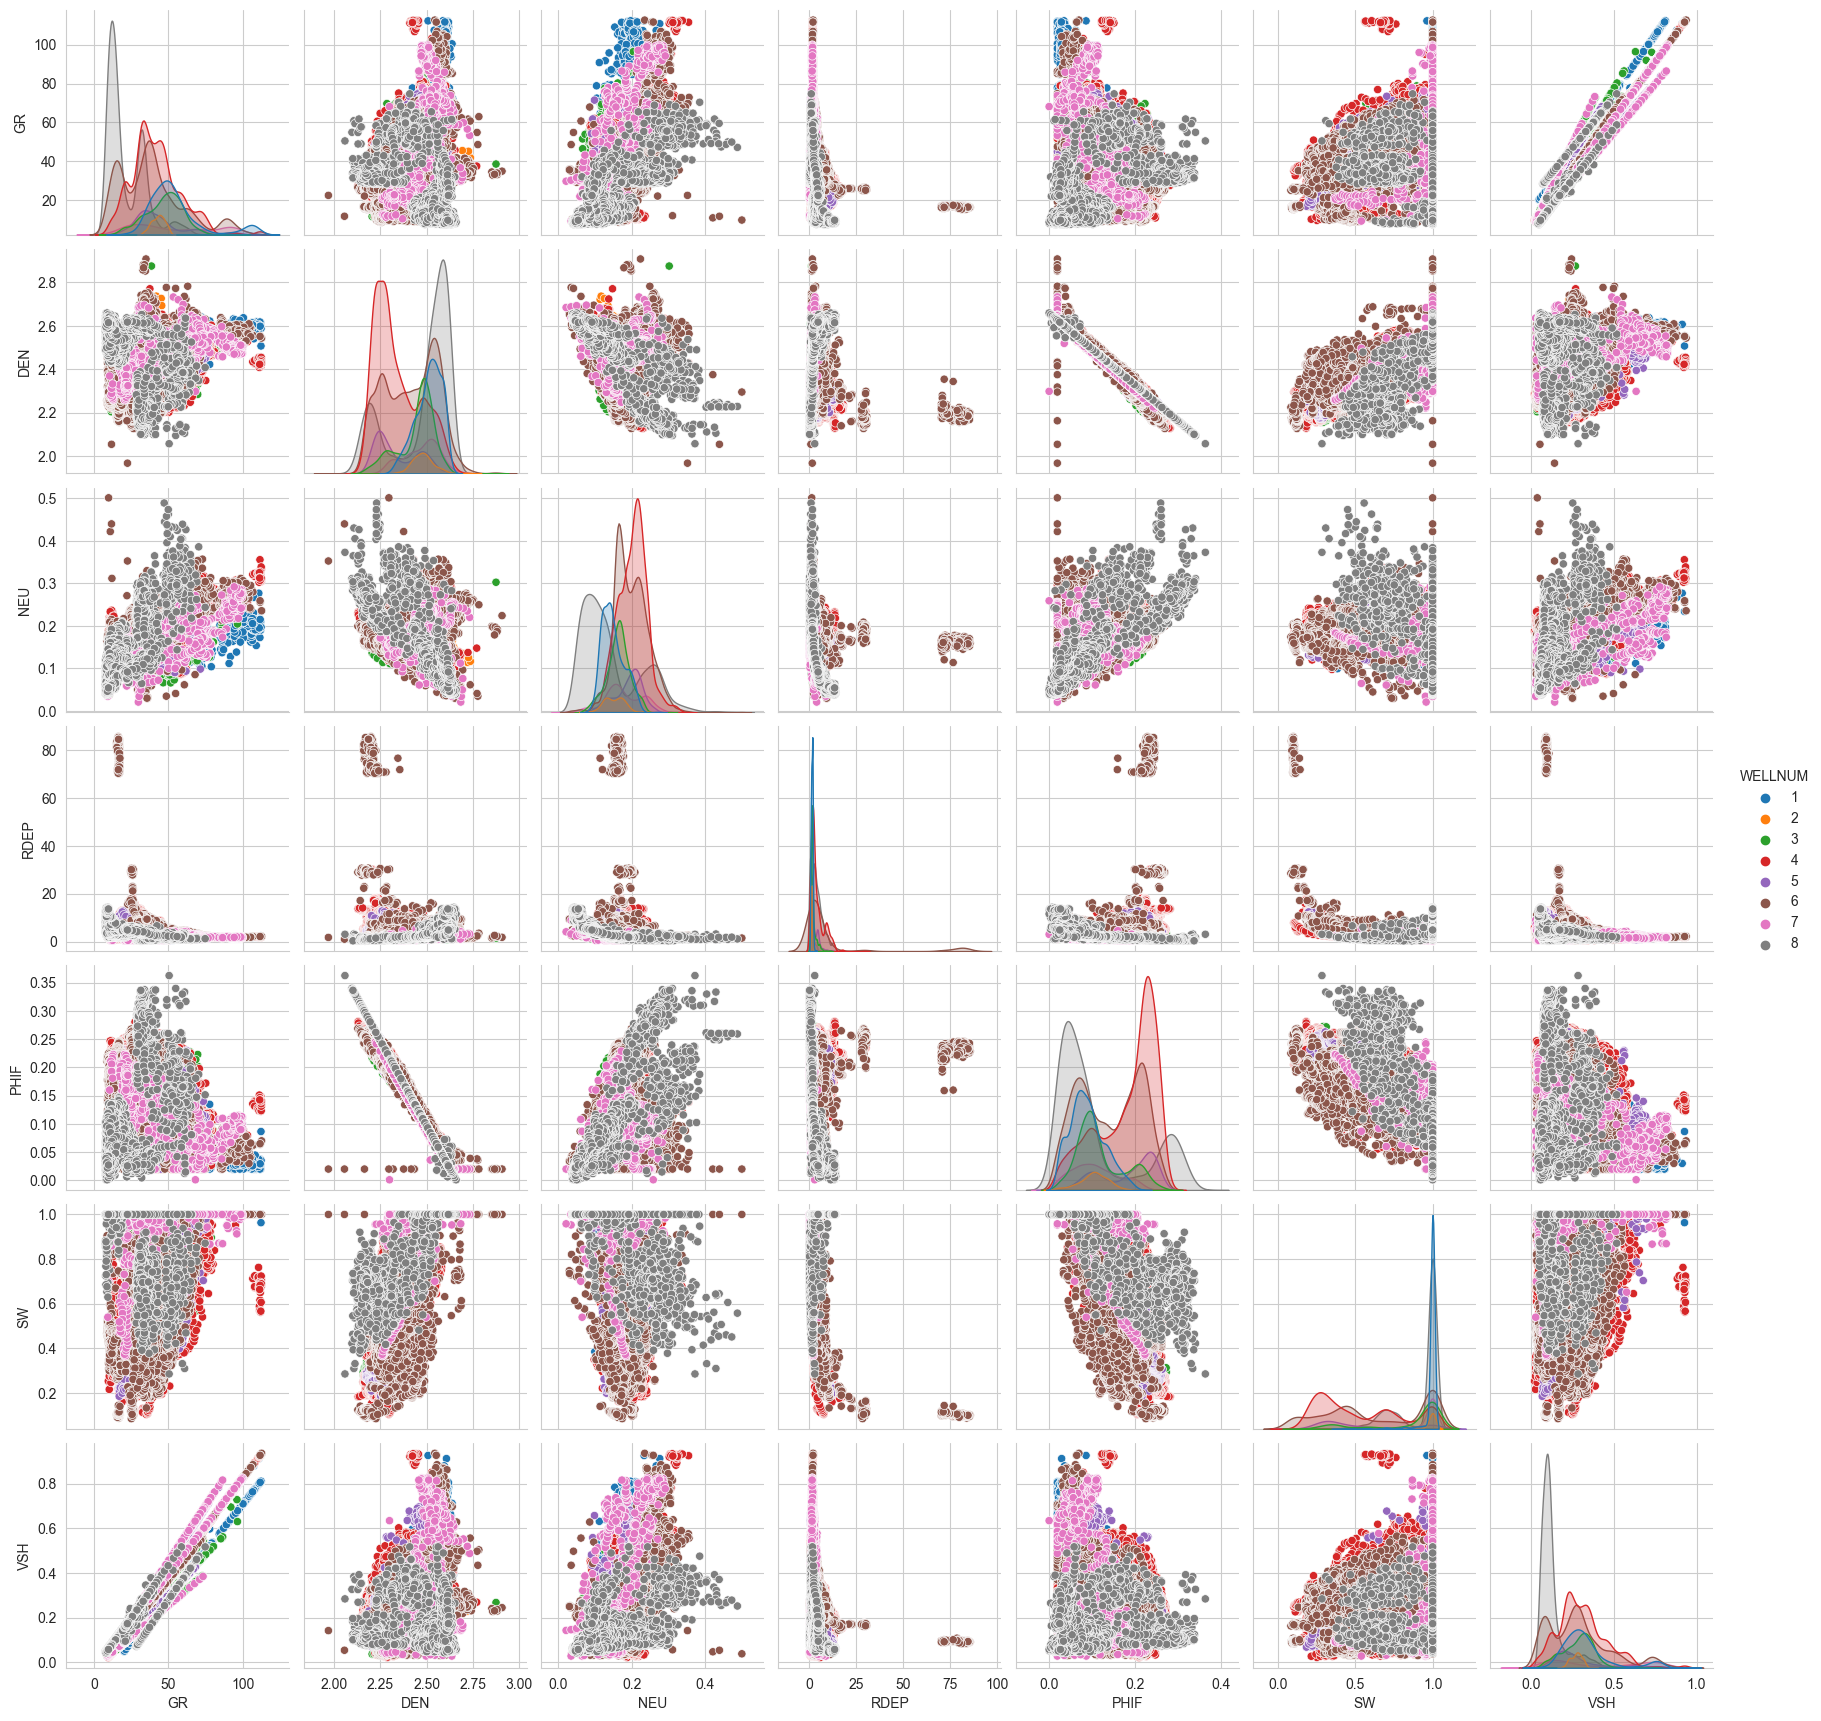

In [28]:
train_new = train_temp.copy()
train_new['WELLNUM'] = train['WELLNUM'].astype('str')
sns.pairplot(train_new[['WELLNUM', 'GR', 'DEN', 'NEU', 'RDEP', 'PHIF', 'SW', 'VSH']], hue='WELLNUM')

In [116]:
train_values = np.array(train_temp[col_names])
X = train_values[:,:-3]
Y = train_values[:,-3:]
# Y = train_values[:,-1]

In [117]:
scaler = RobustScaler()
X = scaler.fit_transform(X)

In [118]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [119]:
train_values

array([[2.637700e+00, 7.250980e+01, 1.051000e-01, ..., 2.000000e-02,
        1.000000e+00, 5.477000e-01],
       [2.618100e+00, 5.822530e+01, 1.047000e-01, ..., 2.380000e-02,
        1.000000e+00, 4.117000e-01],
       [2.587300e+00, 5.271810e+01, 1.061000e-01, ..., 4.130000e-02,
        1.000000e+00, 3.592000e-01],
       ...,
       [2.620479e+00, 2.570403e+01, 9.777380e-02, ..., 2.379500e-02,
        1.000000e+00, 2.054000e-01],
       [2.623435e+00, 2.294222e+01, 8.929480e-02, ..., 2.204800e-02,
        1.000000e+00, 1.793000e-01],
       [2.617516e+00, 2.230438e+01, 9.187610e-02, ..., 2.560200e-02,
        1.000000e+00, 1.733000e-01]])

In [124]:
y_train

array([[0.056   , 1.      , 0.276   ],
       [0.1083  , 1.      , 0.3281  ],
       [0.2367  , 0.6505  , 0.3542  ],
       ...,
       [0.247   , 0.7315  , 0.2089  ],
       [0.0567  , 1.      , 0.2238  ],
       [0.292008, 0.7877  , 0.098   ]])

In [122]:
y_test

array([[0.051 , 1.    , 0.29  ],
       [0.2256, 0.5706, 0.276 ],
       [0.0642, 1.    , 0.2852],
       ...,
       [0.02  , 1.    , 0.4552],
       [0.0388, 1.    , 0.4646],
       [0.074 , 1.    , 0.517 ]])

In [93]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'l2',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0
}

In [127]:
y_predict = []
for i in range(0,3):
    lgb_train = lgb.Dataset(X_train, y_train[:,i])
    lgb_test = lgb.Dataset(X_test, y_test[:,i], reference=lgb_train)

    gbm = lgb.LGBMRegressor(num_leaves=31,
                        learning_rate=0.05,
                        n_estimators=20)
    gbm.fit(X_train, y_train[:,i],
        eval_set=[(X_test, y_test[:,i])],
        eval_metric='l2',
        callbacks=[lgb.early_stopping(5)])

    # predict
    y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration_)
    y_predict.append(y_pred)
    # eval
    rmse_test = mean_squared_error(y_test[:,i], y_pred) ** 0.5
    print(f'The RMSE of prediction is: {rmse_test}')


Training until validation scores don't improve for 5 rounds
Did not meet early stopping. Best iteration is:
[20]	valid_0's l2: 0.000850142
The RMSE of prediction is: 0.029157200522863455
Training until validation scores don't improve for 5 rounds
Did not meet early stopping. Best iteration is:
[20]	valid_0's l2: 0.0140396
The RMSE of prediction is: 0.11848882381706352
Training until validation scores don't improve for 5 rounds
Did not meet early stopping. Best iteration is:
[20]	valid_0's l2: 0.00460082
The RMSE of prediction is: 0.06782934837977717


In [139]:
y_predict = list(map(lambda x: np.array(x).reshape(-1,1), y_predict))

In [142]:
y_predict

[array([[0.08158304],
        [0.19173287],
        [0.08687729],
        ...,
        [0.06222764],
        [0.07502486],
        [0.09433325]]),
 array([[0.90349632],
        [0.64033409],
        [0.90462512],
        ...,
        [0.90462512],
        [0.90462512],
        [0.90366707]]),
 array([[0.27454042],
        [0.33870427],
        [0.28924942],
        ...,
        [0.38432874],
        [0.40030143],
        [0.41271177]])]